# Convolutional layers

In [1]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]

2025-11-16 17:37:04.920835: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


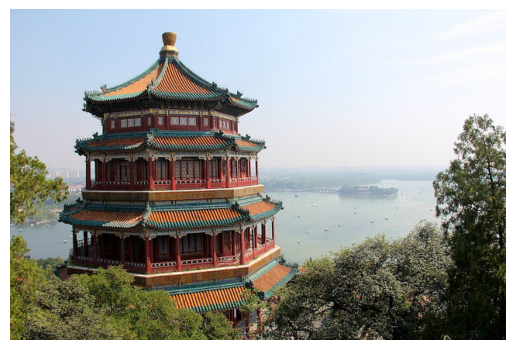

In [2]:
import matplotlib.pyplot as plt

plt.imshow(images[0])
plt.axis("off")
plt.show()

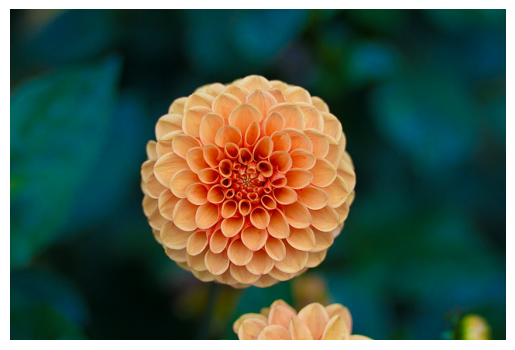

In [3]:
plt.imshow(images[1])
plt.axis("off")
plt.show()

In [4]:
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)

images.shape

W0000 00:00:1763325427.942379     668 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


TensorShape([2, 70, 120, 3])

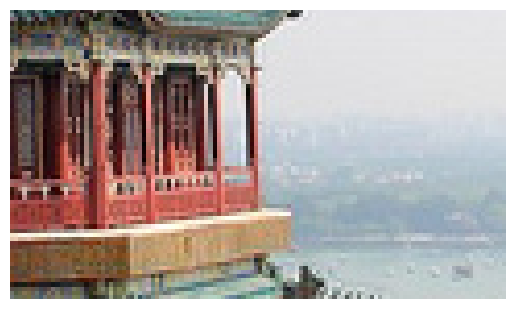

In [5]:
plt.imshow(images[0])
plt.axis("off")
plt.show()

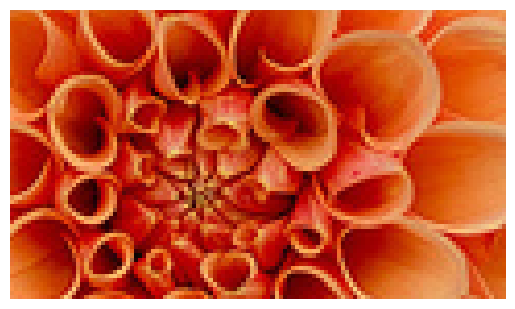

In [6]:
plt.imshow(images[1])
plt.axis("off")
plt.show()

In [7]:
# No padding by default (valid)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7))
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 64, 114, 32])

In [8]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), padding="same")
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 70, 120, 32])

In [9]:
kernels, biases = conv_layer.get_weights()

In [10]:
kernels.shape

(7, 7, 3, 32)

In [11]:
biases.shape

(32,)

# Pooling layers

In [12]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
pooled_images = max_pool(images)
pooled_images.shape

TensorShape([2, 35, 60, 3])

In [13]:
pooled_fmaps = max_pool(fmaps)
pooled_fmaps.shape

TensorShape([2, 35, 60, 32])

In [14]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
# The same as:
# global_avg_pool = tf.keras.layers.Lambda(
#     lambda X: tf.reduce_mean(X, axis=[1, 2])
# )

In [15]:
global_avg_pool(images) # avg of channels (RGB) for each image

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

# CNN architectures

In [16]:
# Example for MNIST

from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=(3, 3), padding="same", activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=(7, 7), input_shape=[28, 28, 1]), # 1 color channel (grayscale)
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    
    # Now the fully connected network:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax"),
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

/home/julio/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Implementing a ResNet-34 CNN

In [17]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=(3, 3), strides=1, 
                        padding="same", kernel_initializer="he_normal", use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization(),
        ]

        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=(1, 1), strides=strides),
                tf.keras.layers.BatchNormalization(),
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)

        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        return self.activation(Z + skip_Z)

In [18]:
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=(7, 7), strides=2, input_shape=[224, 224, 3]), # RGB image of 224x224
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same"),
])
prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Using pretrained models from Keras

In [19]:
model = tf.keras.applications.ResNet50(weights="imagenet")

In [20]:
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True)(images)
images_resized.shape

TensorShape([2, 224, 224, 3])

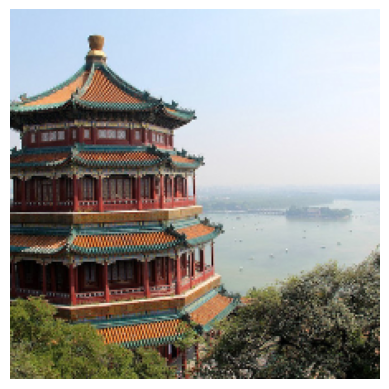

In [21]:
plt.imshow(images_resized[0])
plt.axis("off")
plt.show()

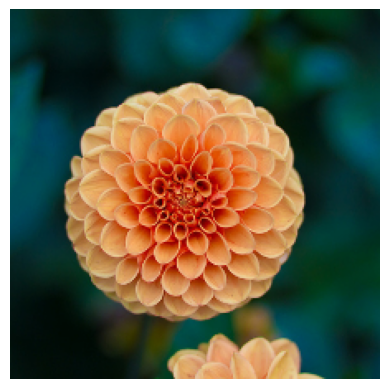

In [22]:
plt.imshow(images_resized[1])
plt.axis("off")
plt.show()

In [23]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)
inputs.shape

TensorShape([2, 224, 224, 3])

In [24]:
Y_proba = model.predict(inputs)
Y_proba.shape
# There are 1000 classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step


(2, 1000)

In [25]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

image #0
  n03598930 - jigsaw_puzzle 30.68%
  n02782093 - balloon      17.17%
  n03888257 - parachute    5.57%
image #1
  n04209133 - shower_cap   34.37%
  n09229709 - bubble       11.41%
  n02782093 - balloon      9.46%


# Pretrained models for transfer learning

In [26]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

dataset_size, class_names, n_classes

(3670, ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], 5)

In [27]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True,
)

In [28]:
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [29]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
])

In [30]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False) # Excluding the top-most layers
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [31]:
# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

In [32]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3


2025-11-16 17:37:15.689424: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


86/86 ━━━━━━━━━━━━━━━━━━━━ 75s 854ms/step - accuracy: 0.8114 - loss: 0.7044 - val_accuracy: 0.8258 - val_loss: 0.6429
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 74s 858ms/step - accuracy: 0.9179 - loss: 0.3122 - val_accuracy: 0.8766 - val_loss: 0.5698
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 69s 806ms/step - accuracy: 0.9360 - loss: 0.1865 - val_accuracy: 0.8639 - val_loss: 0.5140


In [33]:
test_loss, test_accuracy = model.evaluate(test_set)
test_accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 690ms/step - accuracy: 0.8910 - loss: 0.4374


0.891008198261261

In [35]:
# len(base_model.layers)
# Unfreeze top layers to retrain and see if the accuracy improve
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9) # Reducing the learning_rate
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9757 - loss: 0.0877 - val_accuracy: 0.9038 - val_loss: 0.3277
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9909 - loss: 0.0335 - val_accuracy: 0.9274 - val_loss: 0.2487
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9975 - loss: 0.0133 - val_accuracy: 0.9220 - val_loss: 0.2505


In [36]:
test_loss, test_accuracy = model.evaluate(test_set)
test_accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.9128 - loss: 0.2426


0.912806510925293

# Classification and localization

In [37]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer, metrics=["accuracy"])

# Exercises

## 9

In [90]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)

In [91]:
def create_dataset(features, label, buffer_size=128, seed=42, batch_size=32):
    norm_layer = tf.keras.layers.Normalization()
    norm_layer.adapt(features)
    
    dataset = tf.data.Dataset.from_tensor_slices((features, label))
    dataset = dataset.map(lambda X, y: (norm_layer(X), y))
    dataset = dataset.map(lambda X, y: (tf.reshape(X, (28, 28, 1)), y))
    dataset = dataset.shuffle(buffer_size=buffer_size, seed=seed)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    
    return dataset

train_set = create_dataset(X_train, y_train)
test_set = create_dataset(X_test, y_test)
valid_set = create_dataset(X_valid, y_valid)

In [86]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=(3, 3), padding="same", activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=(7, 7), input_shape=[28, 28, 1]), # 1 color channel (grayscale)
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    
    # Now the fully connected network:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax"),
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [88]:
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - accuracy: 0.7191 - loss: 0.8482 - val_accuracy: 0.9826 - val_loss: 0.0764
Epoch 2/3
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.9432 - loss: 0.2023 - val_accuracy: 0.9836 - val_loss: 0.0725
Epoch 3/3
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.9695 - loss: 0.1277 - val_accuracy: 0.9852 - val_loss: 0.0503


In [89]:
test_loss, test_accuracy = model.evaluate(test_set)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9866 - loss: 0.0536


In [ ]:
# 98.66% accuracy

In [102]:
model = tf.keras.Sequential([
    DefaultConv2D(filters=32, kernel_size=(3, 3), input_shape=[28, 28, 1]), # 1 color channel (grayscale)
    DefaultConv2D(filters=64, kernel_size=(3, 3)),
    tf.keras.layers.MaxPool2D(),
    
    # Now the fully connected network:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax"),
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [103]:
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.9092 - loss: 0.3151 - val_accuracy: 0.9870 - val_loss: 0.0518
Epoch 2/3
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.9630 - loss: 0.1278 - val_accuracy: 0.9876 - val_loss: 0.0437
Epoch 3/3
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.9704 - loss: 0.1003 - val_accuracy: 0.9912 - val_loss: 0.0360


In [104]:
test_loss, test_accuracy = model.evaluate(test_set)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9894 - loss: 0.0324


In [95]:
# 98.95% accuracy

## 10